In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
# Cargar datos (ajusta la ruta)
df = pd.read_csv("./datos_territorio/datos_original.csv", thousands=".", decimal=",")

In [3]:
# Convertir columnas a numéricas 
cols_viviendas = ["Viviendas (ocupadas)", "Viviendas (total)"]
df[cols_viviendas] = df[cols_viviendas].apply(pd.to_numeric, errors="coerce")

In [4]:
mask_ocupadas_original = df["Viviendas (ocupadas)"].notna()
mask_total_original = df["Viviendas (total)"].notna()


In [5]:
# Paso 1: Calcular tasa de ocupación (ocupadas / total)
df["Tasa_ocupacion"] = df["Viviendas (ocupadas)"] / df["Viviendas (total)"]

In [6]:
# Paso 2: Imputar tasa de ocupación hacia adelante (LOCF)
df["Tasa_ocupacion_imputada"] = df["Tasa_ocupacion"].ffill()

In [7]:
# Paso 3: Estimar "ocupadas" donde hay "total" pero no "ocupadas"
mask_ocupadas = df["Viviendas (ocupadas)"].isna() & df["Viviendas (total)"].notna()
df.loc[mask_ocupadas, "Viviendas (ocupadas)"] = (
    df.loc[mask_ocupadas, "Viviendas (total)"] * df.loc[mask_ocupadas, "Tasa_ocupacion_imputada"]
)

In [8]:
# Paso 4: Modelar "total" para años anteriores a 2005 (regresión exponencial)
# Filtrar datos conocidos de "total" (años 2005+)
df_total = df.dropna(subset=["Viviendas (total)"]).copy()

In [9]:
df_total.head(5)

,año,población,Huella Urbana,Área protegida,Area disponible,Viviendas (ocupadas),Viviendas (total),Tasa_ocupacion,Tasa_ocupacion_imputada
25,2005,6790992,33506.0,3015.54,130094.0,1623639.0,1685585.0,0.963250,0.963250
26,2006,6873842,NaN,NaN,NaN,1672423.0,1740722.0,0.960764,0.960764
27,2007,6945389,NaN,NaN,NaN,1722999.0,1799363.0,0.957561,0.957561
28,2008,7009432,NaN,NaN,NaN,1775256.0,1861260.0,0.953793,0.953793
29,2009,7062402,NaN,NaN,NaN,1829766.0,1926554.0,0.949761,0.949761


In [10]:
# Crear variable año numérica (si no existe)
df_total["año_numeric"] = df_total["año"] - df_total["año"].min()


In [11]:
df_total.head(5)

,año,población,Huella Urbana,Área protegida,Area disponible,Viviendas (ocupadas),Viviendas (total),Tasa_ocupacion,Tasa_ocupacion_imputada,año_numeric
25,2005,6790992,33506.0,3015.54,130094.0,1623639.0,1685585.0,0.963250,0.963250,0
26,2006,6873842,NaN,NaN,NaN,1672423.0,1740722.0,0.960764,0.960764,1
27,2007,6945389,NaN,NaN,NaN,1722999.0,1799363.0,0.957561,0.957561,2
28,2008,7009432,NaN,NaN,NaN,1775256.0,1861260.0,0.953793,0.953793,3
29,2009,7062402,NaN,NaN,NaN,1829766.0,1926554.0,0.949761,0.949761,4


In [12]:
# Ajustar modelo: log(total) ~ año
X = sm.add_constant(df_total["año"])  # Intercepto
y = np.log(df_total["Viviendas (total)"])
model = sm.OLS(y, X).fit()

In [13]:
# Predecir "total" para todos los años (incluyendo faltantes)
df["total_predicho"] = np.exp(model.predict(sm.add_constant(df["año"])))

In [14]:
# Imputar "total" faltantes con predicciones
mask_total = df["Viviendas (total)"].isna()
df.loc[mask_total, "Viviendas (total)"] = df.loc[mask_total, "total_predicho"]

In [15]:
df

,año,población,Huella Urbana,Área protegida,Area disponible,Viviendas (ocupadas),Viviendas (total),Tasa_ocupacion,Tasa_ocupacion_imputada,total_predicho
0,1980,3753117,NaN,NaN,NaN,NaN,7.785450e+05,NaN,NaN,7.785450e+05
1,1981,3876219,NaN,NaN,NaN,NaN,8.032004e+05,NaN,NaN,8.032004e+05
2,1982,4000258,NaN,NaN,NaN,NaN,8.286365e+05,NaN,NaN,8.286365e+05
3,1983,4125066,NaN,NaN,NaN,NaN,8.548783e+05,NaN,NaN,8.548783e+05
4,1984,4250881,NaN,NaN,NaN,NaN,8.819510e+05,NaN,NaN,8.819510e+05
5,1985,4376707,21210.0,414.72,142390.0,NaN,9.098811e+05,NaN,NaN,9.098811e+05
6,1986,4503632,NaN,NaN,NaN,NaN,9.386957e+05,NaN,NaN,9.386957e+05
7,1987,4629733,NaN,NaN,NaN,NaN,9.684229e+05,NaN,NaN,9.684229e+05
8,1988,4755662,NaN,NaN,NaN,NaN,9.990914e+05,NaN,NaN,9.990914e+05
9,1989,4882163,NaN,NaN,NaN,NaN,1.030731e+06,NaN,NaN,1.030731e+06


In [16]:
# Paso 5: Imputar "ocupadas" para años anteriores a 2005 usando la tasa más antigua
tasa_2005 = df.loc[df["año"] == 2005, "Tasa_ocupacion_imputada"].values[0]
mask_ocupadas_historicas = df["Viviendas (ocupadas)"].isna()
df.loc[mask_ocupadas_historicas, "Viviendas (ocupadas)"] = (
    df.loc[mask_ocupadas_historicas, "Viviendas (total)"] * tasa_2005
)


In [17]:
# Limpiar columnas temporales
df.drop(columns=["total_predicho", "Tasa_ocupacion", "Tasa_ocupacion_imputada"], inplace=True)


In [18]:
df["Viviendas (ocupadas)"] = df["Viviendas (ocupadas)"].round(0)
df["Viviendas (total)"] = df["Viviendas (total)"].round(0)

In [19]:
# Mostrar resultados
df.head(10)

,año,población,Huella Urbana,Área protegida,Area disponible,Viviendas (ocupadas),Viviendas (total)
0,1980,3753117,NaN,NaN,NaN,749933.0,778545.0
1,1981,3876219,NaN,NaN,NaN,773682.0,803200.0
2,1982,4000258,NaN,NaN,NaN,798184.0,828637.0
3,1983,4125066,NaN,NaN,NaN,823461.0,854878.0
4,1984,4250881,NaN,NaN,NaN,849539.0,881951.0
5,1985,4376707,21210.0,414.72,142390.0,876443.0,909881.0
6,1986,4503632,NaN,NaN,NaN,904198.0,938696.0
7,1987,4629733,NaN,NaN,NaN,932833.0,968423.0
8,1988,4755662,NaN,NaN,NaN,962374.0,999091.0
9,1989,4882163,NaN,NaN,NaN,992851.0,1030731.0


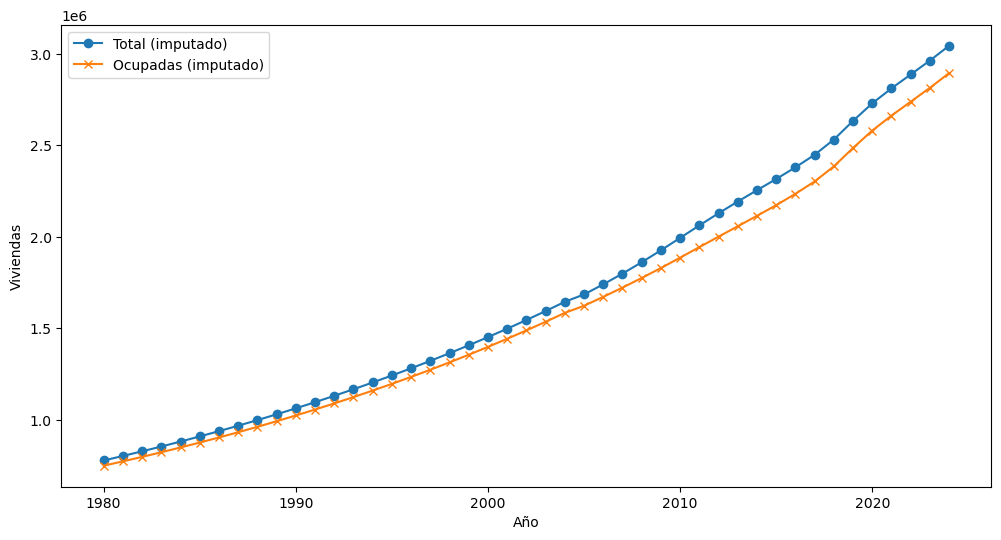

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(df["año"], df["Viviendas (total)"], label="Total (imputado)", marker="o")
plt.plot(df["año"], df["Viviendas (ocupadas)"], label="Ocupadas (imputado)", marker="x")
plt.xlabel("Año")
plt.ylabel("Viviendas")
plt.legend()
plt.show()

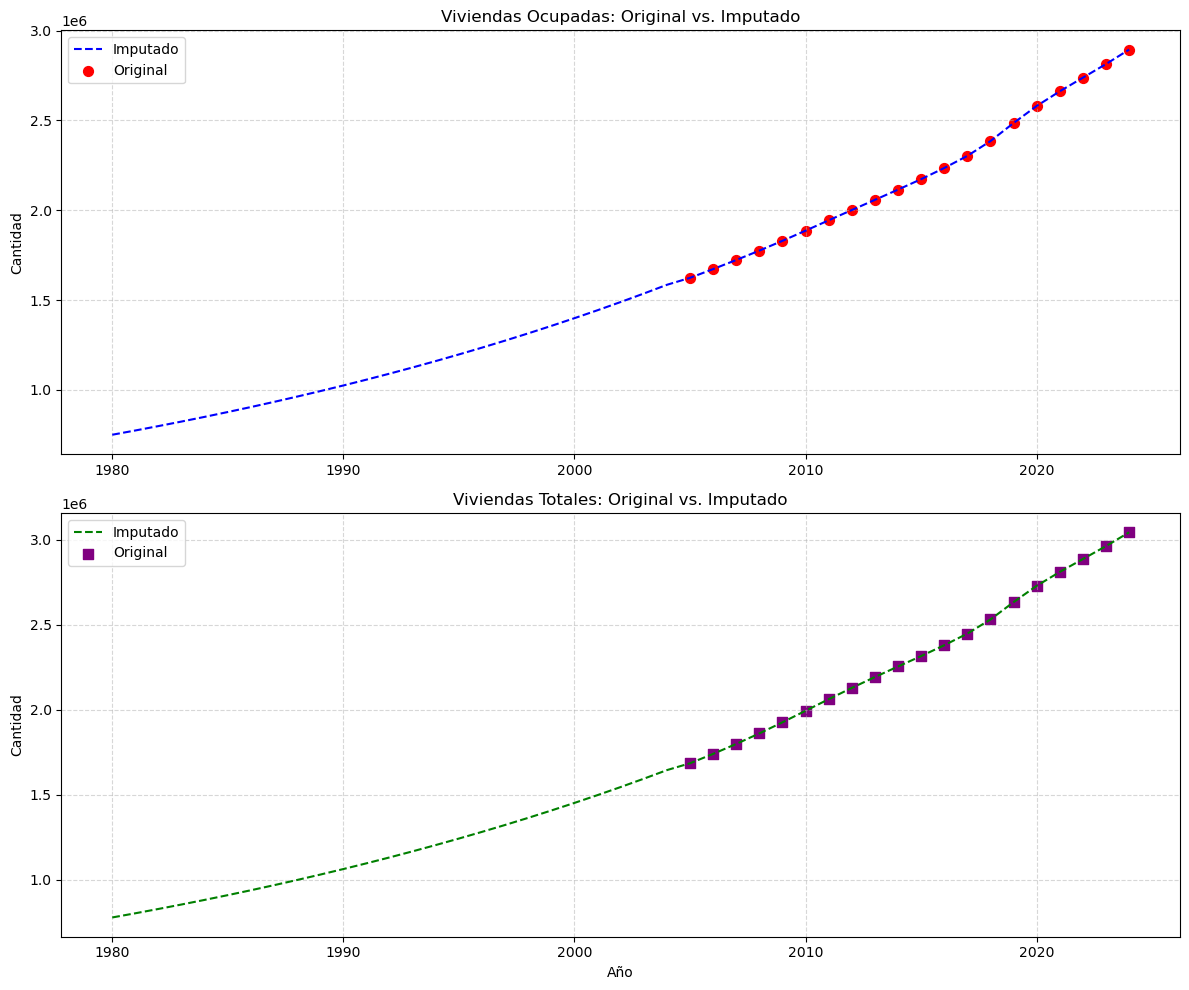

In [21]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Datos imputados (línea)
axes[0].plot(
    df["año"], 
    df["Viviendas (ocupadas)"], 
    color="blue", 
    linestyle="--", 
    label="Imputado"
)

# Datos originales (puntos)
axes[0].scatter(
    df.loc[mask_ocupadas_original, "año"], 
    df.loc[mask_ocupadas_original, "Viviendas (ocupadas)"], 
    color="red", 
    marker="o", 
    s=50, 
    label="Original"
)

axes[0].set_title("Viviendas Ocupadas: Original vs. Imputado")
axes[0].set_ylabel("Cantidad")
axes[0].grid(True, linestyle="--", alpha=0.5)
axes[0].legend()

# Datos imputados (línea)
axes[1].plot(
    df["año"], 
    df["Viviendas (total)"], 
    color="green", 
    linestyle="--", 
    label="Imputado"
)

# Datos originales (puntos)
axes[1].scatter(
    df.loc[mask_total_original, "año"], 
    df.loc[mask_total_original, "Viviendas (total)"], 
    color="purple", 
    marker="s", 
    s=50, 
    label="Original"
)

axes[1].set_title("Viviendas Totales: Original vs. Imputado")
axes[1].set_xlabel("Año")
axes[1].set_ylabel("Cantidad")
axes[1].grid(True, linestyle="--", alpha=0.5)
axes[1].legend()

plt.tight_layout()
plt.show()

In [22]:
df.to_csv("./datos_territorio/datos_vivienda.csv", index=False, encoding="utf-8-sig")